In [1]:
import numpy as np
import torch
import scanpy as sc
import pandas as pd
import os
import yaml
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score as ari_score

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from sklearn.decomposition import PCA


In [2]:
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='imputation', key_added_pred='impute_mclust',
             random_seed=666):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """

    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(adata.obsm[used_obsm], num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs[key_added_pred] = mclust_res
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('int')
    adata.obs[key_added_pred] = adata.obs[key_added_pred].astype('category')
    return adata

In [3]:
from utils.Func import *
from utils.Utils import *
from SpaICL import spaicl

torch.Size([10, 100])


In [4]:
with open('./config/DLPFC_CLFS.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [5]:
proj_name = '151675'
num_clusters = 5 if proj_name in ['151669', '151670', '151671', '151672'] else 7

In [6]:
def off_the_shelf_adata(proj_name):
    adata = sc.read_h5ad(f'data/{proj_name}.h5ad')
    adata.obsm['img_pca'] = torch.tensor(adata.obsm['img_pca'])
    return adata

adata = off_the_shelf_adata('151675')

graph_dict = graph_construction(adata, config['data']['k_cutoff'])

E:\Topic\st cluster\code\CLDCA\utils\Func.py:59: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [7]:
# %%
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = spaicl(adata, graph_dict=graph_dict, num_clusters=num_clusters, device=device, config=config)
para_list = net.train()

Epoch 99 total loss=0.943 recon loss=1.050 match loss=0.418: 100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


In [8]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon

In [9]:
adata = mclust_R(adata, num_cluster=num_clusters, used_obsm='latent', key_added_pred='mclust')
adata.obs['domain'] = refine_label(adata, 30, key='mclust')
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['domain'])
print("ARI:", ARI)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
ARI: 0.6179459983501095


[<Axes: title={'center': 'SpaICL \n ARI:0.618'}, xlabel='spatial1', ylabel='spatial2'>]

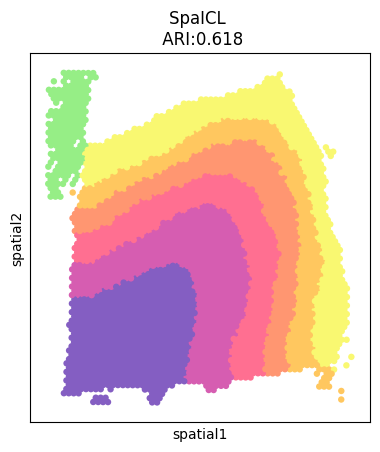

In [10]:
plot_color = ['#96EE86', '#F9F871', '#FFC75F', '#FF9671', '#FF6F91', '#D65DB1', '#845EC2']

maps = {'4': 'Layer_1', '2': 'Layer_5', '3': 'Layer_6', '7': 'Layer_3', '5': 'WM', '6': 'Layer_4',
        '1': 'Layer_2'}
values = [maps[value] for value in adata.obs['domain']]
data = {'cluster': values}
df = pd.DataFrame(data, index=adata.obs['domain'].index)
adata.obs['domain'] = df

sc.pl.spatial(adata, color=['domain'], title='SpaICL \n ARI:' + str(round(ARI, 3)), show=False, legend_loc=None,
              palette=plot_color, spot_size=180, img_key=None, save=False)

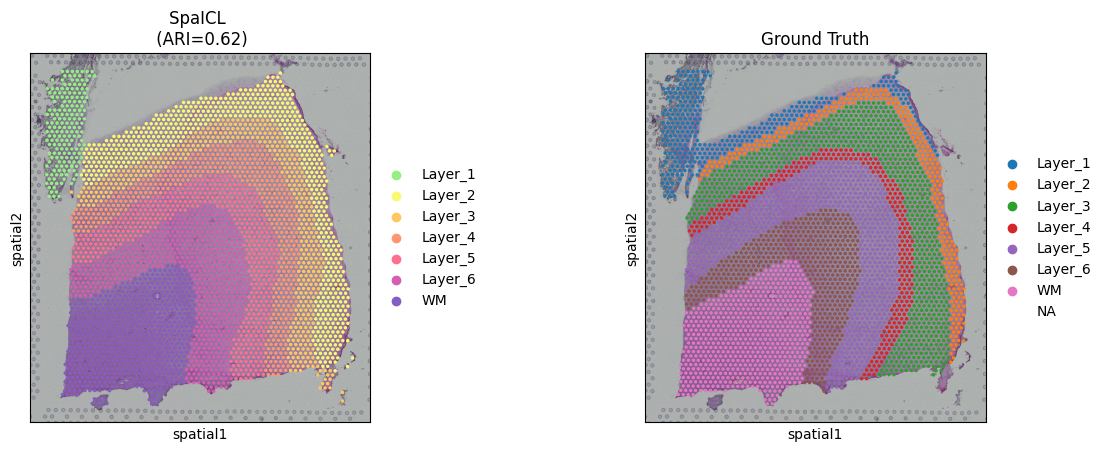

In [11]:
sc.pl.spatial(adata, color=["domain", "layer_guess"], title=[f"SpaICL \n (ARI={ARI:.2f})", "Ground Truth"])

d:\app\python\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

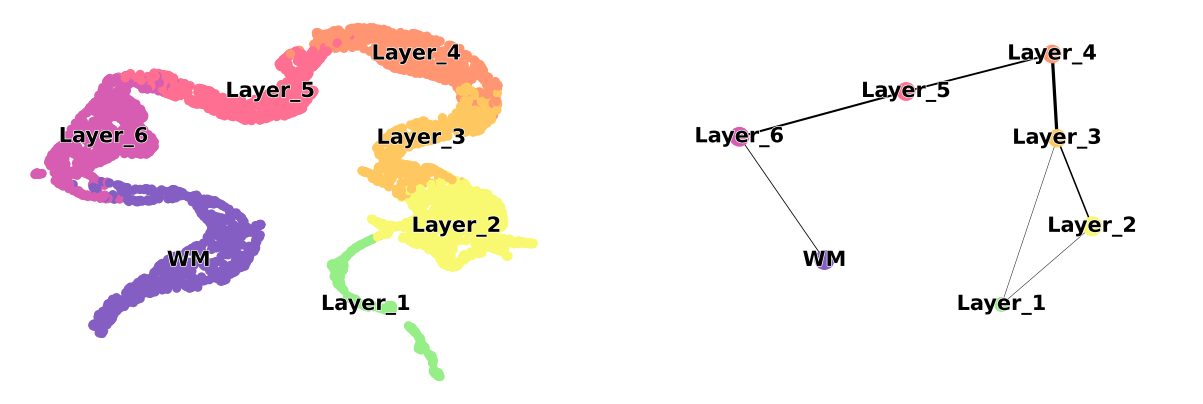

In [12]:
sc.pp.neighbors(adata, n_neighbors=12, n_pcs=16, use_rep='latent')
sc.tl.umap(adata)
sc.tl.paga(adata, groups='domain')
sc.pl.paga_compare(adata, legend_fontsize=15, frameon=False, size=180, legend_fontoutline=1, show=False, save=False, title='')

d:\app\python\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\app\python\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


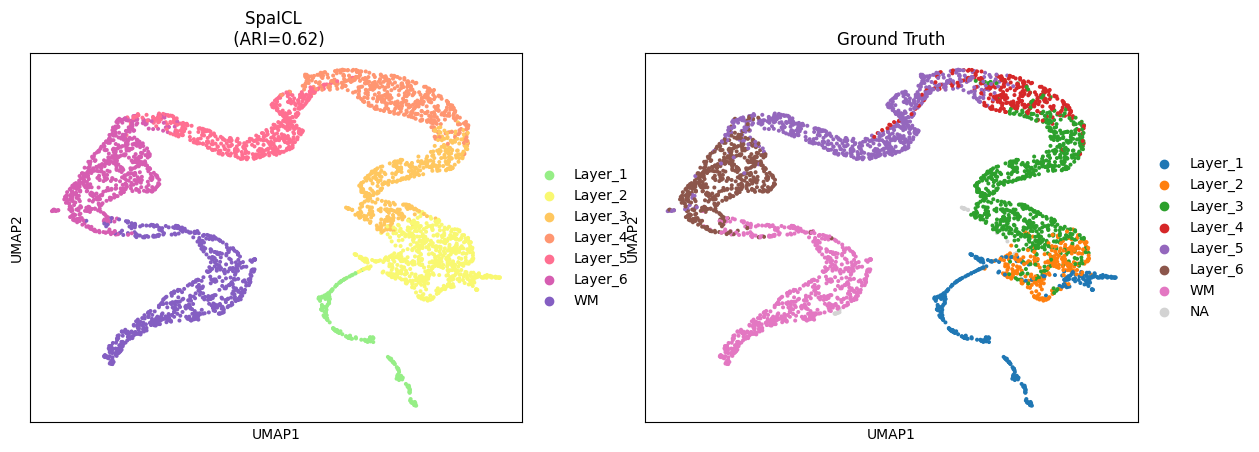

In [13]:
sc.pl.umap(adata, color=["domain", "layer_guess"], title=[f"SpaICL \n (ARI={ARI:.2f})", "Ground Truth"])